<a href="https://colab.research.google.com/github/noralizaaa/Klasifikasi-Burnout-pada-Mahasiswa-dan-Pekerja/blob/main/Deep_Learning_(LSTM).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import Library**

In [ ]:
# ==========================================
# Impor Library yang Dibutuhkan
# ==========================================
from sentence_transformers import SentenceTransformer, util
from datasets import load_dataset
import pandas as pd
import torch
import os
from google.colab import drive
import re
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import RandomOverSampler
from IPython.display import display
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.exceptions import ConvergenceWarning
import warnings

# Download stopwords (dibutuhkan untuk fungsi clean_text)
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

# Abaikan warning konvergensi agar output lebih bersih
warnings.filterwarnings("ignore", category=ConvergenceWarning)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
# ==========================================
# 11. Impor Library Model Klasifikasi
# ==========================================
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.exceptions import ConvergenceWarning
import warnings
import time
import matplotlib.pyplot as plt
import seaborn as sns


# Abaikan warning konvergensi agar output lebih bersih
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.filterwarnings("ignore", category=UserWarning) # Untuk XGBoost

**Load Dataset**

In [ ]:
# ==========================================
# 2. Load Dataset
# ==========================================
file_path = "/content/Burnout_3_Class_Filtered.csv"
df = pd.read_csv(file_path)

print(df.info())
print("\nDistribusi label:\n", df['label'].value_counts())

df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25204 entries, 0 to 25203
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              25204 non-null  object 
 1   label             25204 non-null  object 
 2   label_text        25204 non-null  object 
 3   similarity_score  25204 non-null  float64
dtypes: float64(1), object(3)
memory usage: 787.8+ KB
None

Distribusi label:
 label
worker_burnout     16648
college_burnout     6556
no_burnout          2000
Name: count, dtype: int64


,text,label,label_text,similarity_score
0,i just dont understand why i feel so lost abou...,college_burnout,disappointment,0.404119
1,i feel soo ungrateful today,no_burnout,disappointment,0.492512
2,i do what i do and how i seem to always be pow...,worker_burnout,disappointment,0.459672
3,i need to feel valuable,worker_burnout,joy,0.497510
4,i feel super weak and i havent made it through...,college_burnout,joy,0.405756


In [ ]:
df.tail()

,text,label,label_text,similarity_score
25199,still feeling emotional fragile keeping busy r...,worker_burnout,sadness,0.412409
25200,feel soooooo productive,worker_burnout,joy,0.457388
25201,Quiz in every class tomorrow #cantwait,college_burnout,joy,0.430900
25202,i quit my job in financial services feeling di...,worker_burnout,sadness,0.524909
25203,sad songwe the king frowningface,no_burnout,disappointment,0.426437


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25204 entries, 0 to 25203
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   text              25204 non-null  object 
 1   label             25204 non-null  object 
 2   label_text        25204 non-null  object 
 3   similarity_score  25204 non-null  float64
dtypes: float64(1), object(3)
memory usage: 787.8+ KB


In [ ]:
df.describe()

,similarity_score
count,25204.000000
mean,0.469944
std,0.059296
min,0.400000
25%,0.424923
50%,0.455037
75%,0.499091
max,0.851624


In [ ]:
df.isnull().sum()

,0
text,0
label,0
label_text,0
similarity_score,0


In [ ]:
df.duplicated().sum()

np.int64(0)

**Pre-Processing**

In [ ]:
# ==========================================
# 7. Preprocessing Text (Fungsi Anda)
# ==========================================
# (Ini adalah fungsi yang Anda berikan di prompt pertama)
def clean_text_steps_verbose_all(df_text):
    text_series = df_text.copy()

    # Tahap 1: Lowercase
    print("\n=== 1. Lowercase ===")
    pre = text_series
    post = text_series.str.lower()
    display(pd.DataFrame({"Pre-processed": pre, "Pro-processed": post}).head())
    text_series = post

    # Tahap 2: Hapus URL
    print("\n=== 2. Hapus URL ===")
    pre = text_series
    post = text_series.str.replace(r"http\S+|www\S+|https\S+", "", regex=True)
    display(pd.DataFrame({"Pre-processed": pre, "Pro-processed": post}).head())
    text_series = post

    # Tahap 3: Hapus Emoji / Emoticon
    print("\n=== 3. Hapus Emoji / Emoticon ===")
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"
                               u"\U0001F300-\U0001F5FF"
                               u"\U0001F680-\U0001F6FF"
                               u"\U0001F1E0-\U0001F1FF"
                               "]+", flags=re.UNICODE)
    pre = text_series
    post = text_series.apply(lambda x: emoji_pattern.sub(r'', x))
    display(pd.DataFrame({"Pre-processed": pre, "Pro-processed": post}).head())
    text_series = post

    # Tahap 4: Hapus angka & karakter spesial
    print("\n=== 4. Hapus Angka & Karakter Spesial ===")
    pre = text_series
    post = text_series.str.replace(r"[^a-z\s]", "", regex=True)
    display(pd.DataFrame({"Pre-processed": pre, "Pro-processed": post}).head())
    text_series = post

    # Tahap 5: Hapus spasi berlebih
    print("\n=== 5. Hapus Spasi Berlebih ===")
    pre = text_series
    post = text_series.str.replace(r"\s+", " ", regex=True).str.strip()
    display(pd.DataFrame({"Pre-processed": pre, "Pro-processed": post}).head())
    text_series = post

    # Tahap 6: Hapus Stopwords
    print("\n=== 6. Hapus Stopwords ===")
    pre = text_series
    post = text_series.apply(lambda x: " ".join([w for w in x.split() if w not in stop_words]))
    display(pd.DataFrame({"Pre-processed": pre, "Pro-processed": post}).head())
    text_series = post

    return text_series

# Terapkan ke seluruh dataset
print("\n🧹 Memulai preprocessing pada data final...")
df_final['clean_text'] = clean_text_steps_verbose_all(df_final['text'])

print("\n📌 Hasil akhir preprocessing:")

display(df_final[['text', 'clean_text', 'label']].head())


🧹 Memulai preprocessing pada data final...

=== 1. Lowercase ===


,Pre-processed,Pro-processed
0,i just dont understand why i feel so lost abou...,i just dont understand why i feel so lost abou...
1,i feel soo ungrateful today,i feel soo ungrateful today
2,i do what i do and how i seem to always be pow...,i do what i do and how i seem to always be pow...
3,i need to feel valuable,i need to feel valuable
4,i feel super weak and i havent made it through...,i feel super weak and i havent made it through...



=== 2. Hapus URL ===


,Pre-processed,Pro-processed
0,i just dont understand why i feel so lost abou...,i just dont understand why i feel so lost abou...
1,i feel soo ungrateful today,i feel soo ungrateful today
2,i do what i do and how i seem to always be pow...,i do what i do and how i seem to always be pow...
3,i need to feel valuable,i need to feel valuable
4,i feel super weak and i havent made it through...,i feel super weak and i havent made it through...



=== 3. Hapus Emoji / Emoticon ===


,Pre-processed,Pro-processed
0,i just dont understand why i feel so lost abou...,i just dont understand why i feel so lost abou...
1,i feel soo ungrateful today,i feel soo ungrateful today
2,i do what i do and how i seem to always be pow...,i do what i do and how i seem to always be pow...
3,i need to feel valuable,i need to feel valuable
4,i feel super weak and i havent made it through...,i feel super weak and i havent made it through...



=== 4. Hapus Angka & Karakter Spesial ===


,Pre-processed,Pro-processed
0,i just dont understand why i feel so lost abou...,i just dont understand why i feel so lost abou...
1,i feel soo ungrateful today,i feel soo ungrateful today
2,i do what i do and how i seem to always be pow...,i do what i do and how i seem to always be pow...
3,i need to feel valuable,i need to feel valuable
4,i feel super weak and i havent made it through...,i feel super weak and i havent made it through...



=== 5. Hapus Spasi Berlebih ===


,Pre-processed,Pro-processed
0,i just dont understand why i feel so lost abou...,i just dont understand why i feel so lost abou...
1,i feel soo ungrateful today,i feel soo ungrateful today
2,i do what i do and how i seem to always be pow...,i do what i do and how i seem to always be pow...
3,i need to feel valuable,i need to feel valuable
4,i feel super weak and i havent made it through...,i feel super weak and i havent made it through...



=== 6. Hapus Stopwords ===


,Pre-processed,Pro-processed
0,i just dont understand why i feel so lost abou...,dont understand feel lost though
1,i feel soo ungrateful today,feel soo ungrateful today
2,i do what i do and how i seem to always be pow...,seem always powering along feel inadequate
3,i need to feel valuable,need feel valuable
4,i feel super weak and i havent made it through...,feel super weak havent made whole class two week



📌 Hasil akhir preprocessing:


,text,clean_text,label
0,i just dont understand why i feel so lost abou...,dont understand feel lost though,college_burnout
1,i feel soo ungrateful today,feel soo ungrateful today,no_burnout
2,i do what i do and how i seem to always be pow...,seem always powering along feel inadequate,worker_burnout
3,i need to feel valuable,need feel valuable,worker_burnout
4,i feel super weak and i havent made it through...,feel super weak havent made whole class two week,college_burnout


**Encode Label**

In [ ]:
# ==========================================
# 8. Encode Label & Oversampling
# ==========================================
print("\n🔄 Melakukan Label Encoding dan Oversampling...")
X = df_final["clean_text"].fillna('') # Ganti NaN (jika ada) dengan string kosong
y = df_final["label"]

# Label encoding
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print(f"Label Asli: {le.classes_}")
print(f"Label Encoded: {np.unique(y_encoded)}")

# Oversampling untuk kelas minoritas
ros = RandomOverSampler(random_state=42)
X_reshaped = X.values.reshape(-1, 1)
X_resampled, y_resampled = ros.fit_resample(X_reshaped, y_encoded)
X_resampled = X_resampled.ravel()

print("\nDistribusi Kelas Setelah Oversampling:")
unique, counts = np.unique(y_resampled, return_counts=True)
print(dict(zip(le.inverse_transform(unique), counts)))



🔄 Melakukan Label Encoding dan Oversampling...
Label Asli: ['college_burnout' 'no_burnout' 'worker_burnout']
Label Encoded: [0 1 2]

Distribusi Kelas Setelah Oversampling:
{'college_burnout': np.int64(16648), 'no_burnout': np.int64(16648), 'worker_burnout': np.int64(16648)}


**split dataset**

In [ ]:
# ==========================================
# 9. Split Train-Test
# ==========================================
print("\n🔪 Membagi data menjadi Train dan Test...")
X_train, X_test, y_train, y_test = train_test_split(
    X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled
)
print(f"Ukuran X_train: {len(X_train)}")
print(f"Ukuran X_test: {len(X_test)}")


🔪 Membagi data menjadi Train dan Test...
Ukuran X_train: 39955
Ukuran X_test: 9989


**Feature Extraction**

In [ ]:
# ==========================================
# 10. Feature Extraction (4 METODE TERPISAH)
# ==========================================
# (Ini mengasumsikan X_train, X_test, y_train, y_test sudah ada dari split)

# --- Metode 1: TF-IDF (Unigrams) ---
print("\n1️⃣ Menerapkan Metode 1: TF-IDF (Unigrams)...")
tfidf_vec_uni = TfidfVectorizer(
    ngram_range=(1, 1),      # Hanya unigrams
    max_features=10000,
    max_df=0.95,
    min_df=5
)
X_train_tfidf_uni = tfidf_vec_uni.fit_transform(X_train)
X_test_tfidf_uni = tfidf_vec_uni.transform(X_test)
print(f"Bentuk X_train_tfidf_uni: {X_train_tfidf_uni.shape}")

# --- Metode 2: TF-IDF (dengan N-grams) ---
print("\n2️⃣ Menerapkan Metode 2: TF-IDF (N-grams)...")
tfidf_vec_ng = TfidfVectorizer(
    ngram_range=(1, 3),      # Unigrams, Bigrams, dan Trigrams
    max_features=15000,      # N-grams butuh lebih banyak fitur
    max_df=0.95,
    min_df=5
)
X_train_tfidf_ng = tfidf_vec_ng.fit_transform(X_train)
X_test_tfidf_ng = tfidf_vec_ng.transform(X_test)
print(f"Bentuk X_train_tfidf_ng: {X_train_tfidf_ng.shape}")

# --- Metode 3: LDA (Latent Dirichlet Allocation) ---
print("\n3️⃣ Menerapkan Metode 3: LDA...")
print("Membuat CountVectorizer (unigrams) untuk input LDA...")
count_vec_lda = CountVectorizer(
    ngram_range=(1, 1),
    max_features=5000,
    max_df=0.90,
    min_df=10,
    stop_words='english' # Gunakan stopwords bawaan sklearn untuk LDA
)
X_train_counts = count_vec_lda.fit_transform(X_train)
X_test_counts = count_vec_lda.transform(X_test)

n_topics = 15 # Anda bisa sesuaikan jumlah topik
print(f"Fitting LDA dengan {n_topics} topik...")
lda = LatentDirichletAllocation(
    n_components=n_topics,
    random_state=42,
    n_jobs=-1,
    learning_method='batch'
)
X_train_lda = lda.fit_transform(X_train_counts)
X_test_lda = lda.transform(X_test_counts)
print(f"Bentuk X_train_lda (fitur): {X_train_lda.shape}")

# --- Metode 4: Bag-of-Words (BoW) (Unigrams) ---
print("\n4️⃣ Menerapkan Metode 4: Bag-of-Words (BoW)...")
bow_vec_uni = CountVectorizer(
    ngram_range=(1, 1),
    max_features=10000,
    max_df=0.95,
    min_df=5
)
X_train_bow_uni = bow_vec_uni.fit_transform(X_train)
X_test_bow_uni = bow_vec_uni.transform(X_test)
print(f"Bentuk X_train_bow_uni: {X_train_bow_uni.shape}")

print("\n\n✅✅✅ Proses Feature Extraction Selesai ✅✅✅")


1️⃣ Menerapkan Metode 1: TF-IDF (Unigrams)...
Bentuk X_train_tfidf_uni: (39955, 5025)

2️⃣ Menerapkan Metode 2: TF-IDF (N-grams)...
Bentuk X_train_tfidf_ng: (39955, 15000)

3️⃣ Menerapkan Metode 3: LDA...
Membuat CountVectorizer (unigrams) untuk input LDA...
Fitting LDA dengan 15 topik...
Bentuk X_train_lda (fitur): (39955, 15)

4️⃣ Menerapkan Metode 4: Bag-of-Words (BoW)...
Bentuk X_train_bow_uni: (39955, 5025)


✅✅✅ Proses Feature Extraction Selesai ✅✅✅


In [ ]:
# ==========================================
# RNN / LSTM TANPA PRETRAINED
# ==========================================
print("\n🧱 Menyiapkan Tokenizer untuk RNN/LSTM...")

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

MAX_WORDS = 20000     # jumlah kata unik
MAX_LEN = 200         # panjang maksimal sequence

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Konversi teks → sequence
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Padding agar panjangnya rata
X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_LEN, padding='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_LEN, padding='post')

print("Bentuk X_train_pad:", X_train_pad.shape)
print("Bentuk X_test_pad:", X_test_pad.shape)



🧱 Menyiapkan Tokenizer untuk RNN/LSTM...
Bentuk X_train_pad: (39955, 200)
Bentuk X_test_pad: (9989, 200)


In [ ]:
# ==========================================
# MODEL RNN
# ==========================================
print("\n🧠 Membangun model Simple RNN...")

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout

num_classes = len(le.classes_)

model_rnn = Sequential([
    Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    SimpleRNN(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_rnn.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_rnn.summary()

print("⏳ Training RNN...")
history_rnn = model_rnn.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    verbose=1
)

print("\n🔍 Evaluasi RNN...")
y_pred_rnn = model_rnn.predict(X_test_pad).argmax(axis=1)

print(classification_report(y_test, y_pred_rnn, target_names=le.classes_))



🧠 Membangun model Simple RNN...


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn (SimpleRNN)          │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

⏳ Training RNN...
Epoch 1/5
999/999 ━━━━━━━━━━━━━━━━━━━━ 26s 21ms/step - accuracy: 0.3296 - loss: 1.1450 - val_accuracy: 0.3385 - val_loss: 1.1101
Epoch 2/5
999/999 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.3334 - loss: 1.1136 - val_accuracy: 0.3317 - val_loss: 1.0987
Epoch 3/5
999/999 ━━━━━━━━━━━━━━━━━━━━ 18s 18ms/step - accuracy: 0.3307 - loss: 1.0995 - val_accuracy: 0.3335 - val_loss: 1.0986
Epoch 4/5
999/999 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.3366 - loss: 1.0988 - val_accuracy: 0.3348 - val_loss: 1.0987
Epoch 5/5
999/999 ━━━━━━━━━━━━━━━━━━━━ 19s 19ms/step - accuracy: 0.3408 - loss: 1.0988 - val_accuracy: 0.3348 - val_loss: 1.0986

🔍 Evaluasi RNN...
313/313 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step
                 precision    recall  f1-score   support

college_burnout       0.00      0.00      0.00      3329
     no_burnout       0.33      1.00      0.50      3330
 worker_burnout       0.00      0.00      0.00      3330

       accuracy                           0.33 

In [ ]:
# ==========================================
# MODEL LSTM
# ==========================================
print("\n🧠 Membangun model LSTM...")

from tensorflow.keras.layers import LSTM

model_lstm = Sequential([
    Embedding(MAX_WORDS, 128, input_length=MAX_LEN),
    LSTM(128, return_sequences=False),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

model_lstm.summary()

print("⏳ Training LSTM...")
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    validation_split=0.2,
    epochs=5,
    batch_size=32,
    verbose=1
)

print("\n🔍 Evaluasi LSTM...")
y_pred_lstm = model_lstm.predict(X_test_pad).argmax(axis=1)

print(classification_report(y_test, y_pred_lstm, target_names=le.classes_))



🧠 Membangun model LSTM...


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

⏳ Training LSTM...
Epoch 1/5
999/999 ━━━━━━━━━━━━━━━━━━━━ 19s 13ms/step - accuracy: 0.3283 - loss: 1.0999 - val_accuracy: 0.3348 - val_loss: 1.0987
Epoch 2/5
999/999 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.3261 - loss: 1.0990 - val_accuracy: 0.3348 - val_loss: 1.0986
Epoch 3/5
999/999 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.3296 - loss: 1.0987 - val_accuracy: 0.3317 - val_loss: 1.0986
Epoch 4/5
999/999 ━━━━━━━━━━━━━━━━━━━━ 14s 14ms/step - accuracy: 0.3343 - loss: 1.0987 - val_accuracy: 0.3317 - val_loss: 1.0987
Epoch 5/5
999/999 ━━━━━━━━━━━━━━━━━━━━ 13s 13ms/step - accuracy: 0.3356 - loss: 1.0987 - val_accuracy: 0.3335 - val_loss: 1.0987

🔍 Evaluasi LSTM...
313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
                 precision    recall  f1-score   support

college_burnout       0.00      0.00      0.00      3329
     no_burnout       0.00      0.00      0.00      3330
 worker_burnout       0.33      1.00      0.50      3330

       accuracy                           0.3

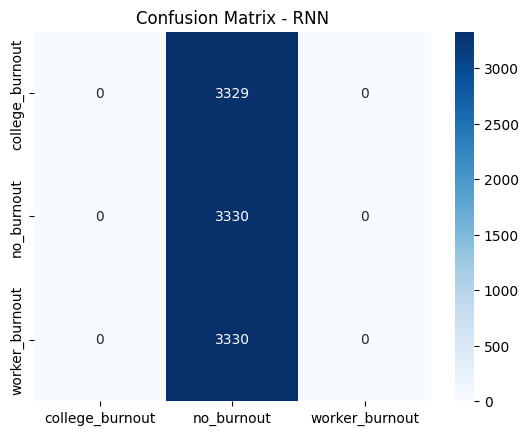

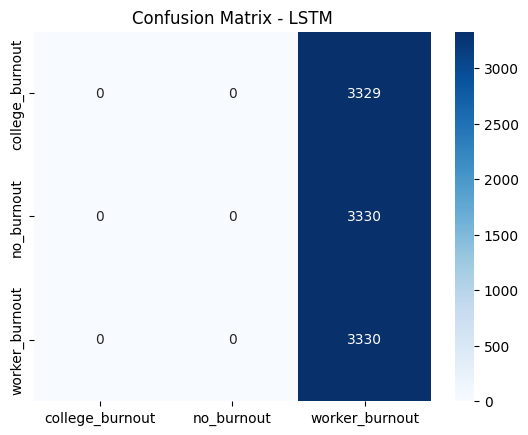

In [ ]:
# Confusion Matrix untuk RNN
cm_rnn = confusion_matrix(y_test, y_pred_rnn)
sns.heatmap(cm_rnn, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - RNN")
plt.show()

# Confusion Matrix untuk LSTM
cm_lstm = confusion_matrix(y_test, y_pred_lstm)
sns.heatmap(cm_lstm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - LSTM")
plt.show()




🤖 MEMULAI TRAINING MODEL BIDIRECTIONAL LSTM
🔤 Melakukan tokenisasi teks...
📏 Memakai max_len = 150
Bentuk X_train_pad: (39955, 150)
Bentuk X_test_pad : (9989, 150)
Jumlah kelas: 3


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_2 (Embedding)         │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ bidirectional (Bidirectional)   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

None

🚀 Training Bidirectional LSTM...
Epoch 1/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 15s 20ms/step - accuracy: 0.6676 - loss: 0.7046 - val_accuracy: 0.8977 - val_loss: 0.2818
Epoch 2/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9189 - loss: 0.2307 - val_accuracy: 0.9209 - val_loss: 0.2291
Epoch 3/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9429 - loss: 0.1621 - val_accuracy: 0.9329 - val_loss: 0.1929
Epoch 4/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9557 - loss: 0.1259 - val_accuracy: 0.9380 - val_loss: 0.1917
Epoch 5/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9630 - loss: 0.1033 - val_accuracy: 0.9347 - val_loss: 0.2036
Epoch 6/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - accuracy: 0.9678 - loss: 0.0882 - val_accuracy: 0.9321 - val_loss: 0.2414
Epoch 7/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 19ms/step - accuracy: 0.9701 - loss: 0.0829 - val_accuracy: 0.9437 - val_loss: 0.2013
Epoch 8/8
625/625 ━━━━━━━━━━━━━━━━━━━━ 12s 20ms/step - acc

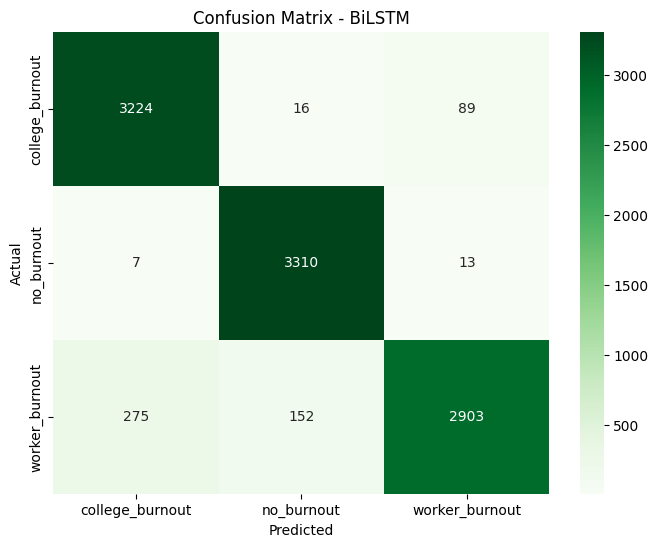

In [ ]:
# ==========================================
# 15. Metode 5: Deep Learning (Bidirectional LSTM)
# ==========================================
print("\n\n==============================================")
print("🤖 MEMULAI TRAINING MODEL BIDIRECTIONAL LSTM")
print("==============================================")

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense, Dropout

# -------------------------------------------------
# 15.1 Tokenization untuk LSTM
# -------------------------------------------------
print("🔤 Melakukan tokenisasi teks...")
vocab_size = 50000  # cukup besar untuk dataset burnout
oov_token = "<OOV>"

tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(X_resampled)  # gunakan data hasil oversampling

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# -------------------------------------------------
# 15.2 Padding (agar semua panjangnya sama)
# -------------------------------------------------
max_len = 150  # panjang umum untuk tweet/short text
print(f"📏 Memakai max_len = {max_len}")

X_train_pad = pad_sequences(X_train_seq, maxlen=max_len, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_len, padding='post', truncating='post')

print("Bentuk X_train_pad:", X_train_pad.shape)
print("Bentuk X_test_pad :", X_test_pad.shape)

# -------------------------------------------------
# 15.3 Membangun model BiLSTM
# -------------------------------------------------
num_classes = len(le.classes_)
print("Jumlah kelas:", num_classes)

model_lstm = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),

    Bidirectional(LSTM(64, return_sequences=False)),

    Dropout(0.4),

    Dense(64, activation='relu'),
    Dropout(0.3),

    Dense(num_classes, activation='softmax')
])

model_lstm.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)

print(model_lstm.summary())

# -------------------------------------------------
# 15.4 Training
# -------------------------------------------------
print("\n🚀 Training Bidirectional LSTM...")
history_lstm = model_lstm.fit(
    X_train_pad, y_train,
    validation_data=(X_test_pad, y_test),
    epochs=8,
    batch_size=64,
    verbose=1
)

# -------------------------------------------------
# 15.5 Evaluate
# -------------------------------------------------
print("\n📊 Evaluasi Model BiLSTM...")
loss, acc = model_lstm.evaluate(X_test_pad, y_test, verbose=0)
print(f"🎉 Akurasi Test BiLSTM: {acc*100:.2f}%")

# Prediksi & Classification Report
y_pred_lstm = model_lstm.predict(X_test_pad)
y_pred_lstm = y_pred_lstm.argmax(axis=1)

print("\nLaporan Klasifikasi BiLSTM:")
print(classification_report(
    y_test,
    y_pred_lstm,
    target_names=le.classes_,
    zero_division=0
))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_lstm)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix - BiLSTM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()